In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, metrics
plt.style.use('ggplot')

In [2]:
# Read in the dataframes
train_df = pd.read_parquet('../input/train_df.parquet.gzip')
test_df = pd.read_parquet('../input/test_df.parquet.gzip')
merch_df = pd.read_parquet('../input/merch_df.parquet.gzip')
hist_trans_df = pd.read_parquet('../input/hist_trans_df.parquet.gzip')
new_trans_df = pd.read_parquet('../input/new_trans_df.parquet.gzip')
ss_df = pd.read_parquet('../input/ss_df.parquet.gzip')

In [3]:
# create some features for historic transactions
hist_trans_df = pd.merge(left=hist_trans_df,
                         right=merch_df[['merchant_id', 'merchant_group_id', 'category_4']],
                         on=['merchant_id'],
                         how='left')
hist_trans_df['year'] = hist_trans_df['purchase_date'].dt.year.astype('category')
hist_trans_df['month'] = hist_trans_df['purchase_date'].dt.month.astype('category')
hist_trans_df['dow'] = hist_trans_df['purchase_date'].dt.dayofweek.astype('category')
hist_trans_df['hour'] = hist_trans_df['purchase_date'].dt.hour
hist_trans_df['day_part'] = 'Morning'
hist_trans_df.loc[(hist_trans_df['hour'] > 12) & (hist_trans_df['hour'] <= 18), 'day_part'] = 'Afternoon'
hist_trans_df.loc[(hist_trans_df['hour'] > 18) & (hist_trans_df['hour'] <= 24), 'day_part'] = 'Evening'
hist_trans_df['installments_flag'] = np.where(hist_trans_df['installments'] > 1, 'Y', 'N')
# convert into proper data types
hist_trans_df['hour'] = hist_trans_df['hour'].astype('category')
hist_trans_df['day_part'] = hist_trans_df['day_part'].astype('category')
hist_trans_df['installments_flag'] = hist_trans_df['installments_flag'].astype('category')
hist_trans_df['dummy'] = 1
hist_trans_df.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,subsector_id,merchant_group_id,category_4,year,month,dow,hour,day_part,installments_flag,dummy
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,37,35,Y,2017,6,6,15,Afternoon,N,1
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,...,16,2084,Y,2017,7,5,12,Morning,N,1
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,37,27369,Y,2017,8,2,22,Evening,N,1
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,34,24104,Y,2017,9,5,10,Morning,N,1
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,37,35,Y,2017,3,4,1,Morning,N,1


In [4]:
hist_trans_df.dtypes

authorized_flag               category
card_id                         object
city_id                       category
category_1                    category
installments                     int64
category_3                    category
merchant_category_id          category
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                      category
subsector_id                  category
merchant_group_id             category
category_4                    category
year                          category
month                         category
dow                           category
hour                          category
day_part                      category
installments_flag             category
dummy                            int64
dtype: object

In [5]:
# save and compress into parquet file format
if False:
    hist_trans_df.to_parquet('../input/hist_trans_merged_df.parquet.gzip',
                             engine='fastparquet',
                             compression='gzip')

In [6]:
# create some features for new transactions
new_trans_df = pd.merge(left=new_trans_df,
                        right=merch_df[['merchant_id', 'merchant_group_id', 'category_4']],
                        on=['merchant_id'],
                        how='left')
new_trans_df['year'] = new_trans_df['purchase_date'].dt.year.astype('category')
new_trans_df['month'] = new_trans_df['purchase_date'].dt.month.astype('category')
new_trans_df['dow'] = new_trans_df['purchase_date'].dt.dayofweek.astype('category')
new_trans_df['hour'] = new_trans_df['purchase_date'].dt.hour
new_trans_df['day_part'] = 'Morning'
new_trans_df.loc[(new_trans_df['hour'] > 12) & (new_trans_df['hour'] <= 18), 'day_part'] = 'Afternoon'
new_trans_df.loc[(new_trans_df['hour'] > 18) & (new_trans_df['hour'] <= 24), 'day_part'] = 'Evening'
new_trans_df['installments_flag'] = np.where(new_trans_df['installments'] > 1, 'Y', 'N')
# convert into proper data types
new_trans_df['hour'] = new_trans_df['hour'].astype('category')
new_trans_df['day_part'] = new_trans_df['day_part'].astype('category')
new_trans_df['installments_flag'] = new_trans_df['installments_flag'].astype('category')
new_trans_df['dummy'] = 1
new_trans_df.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,subsector_id,merchant_group_id,category_4,year,month,dow,hour,day_part,installments_flag,dummy
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,...,19,71460,N,2018,3,6,14,Afternoon,N,1
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,...,19,48955,N,2018,3,0,18,Afternoon,N,1
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,...,14,24380,N,2018,4,3,14,Afternoon,N,1
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,...,8,6938,Y,2018,3,2,9,Morning,N,1
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,...,29,87381,Y,2018,3,3,21,Evening,N,1


In [7]:
new_trans_df.dtypes

authorized_flag               category
card_id                         object
city_id                       category
category_1                    category
installments                     int64
category_3                    category
merchant_category_id          category
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                      category
subsector_id                  category
merchant_group_id             category
category_4                    category
year                          category
month                         category
dow                           category
hour                          category
day_part                      category
installments_flag             category
dummy                            int64
dtype: object

In [8]:
# save and compress into parquet file format
if False:
    new_trans_df.to_parquet('../input/new_trans_merged_df.parquet.gzip',
                            engine='fastparquet',
                            compression='gzip')

####################### Create features from historical transactions #######################

In [9]:
# create card features from historic transactions - purchase date 
hist_agg_date_df = hist_trans_df.groupby('card_id')['purchase_date'].agg(['min', 'max']).reset_index()
hist_agg_date_df.columns = ['card_id', 'hist_date_min', 'hist_date_max']
hist_agg_date_df.head(5)

,card_id,hist_date_min,hist_date_max
0,C_ID_00007093c1,2017-02-14 14:00:43,2018-02-27 05:14:57
1,C_ID_0001238066,2017-09-28 22:25:14,2018-02-27 16:18:59
2,C_ID_0001506ef0,2017-01-14 16:16:01,2018-02-17 12:33:56
3,C_ID_0001793786,2017-01-21 10:15:21,2017-10-31 20:20:18
4,C_ID_000183fdda,2017-08-07 09:49:14,2018-02-25 20:57:08


In [10]:
hist_agg_amount_df = hist_trans_df.groupby('card_id')['purchase_amount']\
    .agg(['min', 'max', 'median', 'std', 'sum', 'count']).reset_index()
hist_agg_amount_df.columns = ['card_id', 
                              'hist_trans_min', 'hist_trans_max',
                              'hist_trans_median', 'hist_trans_std',
                              'hist_trans_sum', 'hist_trans_count']
hist_agg_amount_df.head(5)

,card_id,hist_trans_min,hist_trans_max,hist_trans_median,hist_trans_std,hist_trans_sum,hist_trans_count
0,C_ID_00007093c1,-0.728876,1.507069,-0.587627,0.298141,-76.845041,149
1,C_ID_0001238066,-0.734887,0.768095,-0.648184,0.190235,-72.447201,123
2,C_ID_0001506ef0,-0.740491,1.493545,-0.705585,0.466354,-36.037843,68
3,C_ID_0001793786,-0.745405,4.554145,-0.493185,0.826433,-39.408680,222
4,C_ID_000183fdda,-0.737892,2.764788,-0.659754,0.516910,-72.033025,149


In [11]:
hist_agg_auth_amount_df = hist_trans_df.pivot_table(index='card_id',
                                                    columns='authorized_flag',
                                                    values='purchase_amount',
                                                    fill_value=0,
                                                    dropna=False,
                                                    aggfunc=['min', 'max', 'median', 'std', 'sum', 'count'])
hist_agg_auth_amount_df.columns = ['hist_auth_min_n', 'hist_auth_min_y',
                                   'hist_auth_max_n', 'hist_auth_max_y',
                                   'hist_auth_median_n', 'hist_auth_median_y',
                                   'hist_auth_std_n', 'hist_auth_std_y',
                                   'hist_auth_sum_n', 'hist_auth_sum_y',
                                   'hist_auth_count_n', 'hist_auth_count_y']
hist_agg_auth_amount_df = hist_agg_auth_amount_df.reset_index()
hist_agg_auth_amount_df.head(5)

,card_id,hist_auth_min_n,hist_auth_min_y,hist_auth_max_n,hist_auth_max_y,hist_auth_median_n,hist_auth_median_y,hist_auth_std_n,hist_auth_std_y,hist_auth_sum_n,hist_auth_sum_y,hist_auth_count_n,hist_auth_count_y
0,C_ID_00007093c1,-0.728876,-0.728876,1.507069,1.206539,-0.569219,-0.596643,0.430059,0.237426,-14.401965,-62.443076,35,114
1,C_ID_0001238066,-0.596643,-0.734887,-0.596643,0.768095,-0.596643,-0.650122,0.000000,0.192614,-1.789928,-70.657273,3,120
2,C_ID_0001506ef0,-0.740491,-0.740491,-0.708590,1.493545,-0.728350,-0.701077,0.016203,0.478203,-2.905782,-33.132061,4,64
3,C_ID_0001793786,-0.745405,-0.737892,1.236592,4.554145,-0.566620,-0.459871,0.498150,0.856762,-11.825339,-27.583341,27,195
4,C_ID_000183fdda,-0.714541,-0.737892,0.334099,2.764788,-0.339389,-0.670355,0.452741,0.515166,-0.941381,-71.091644,7,142


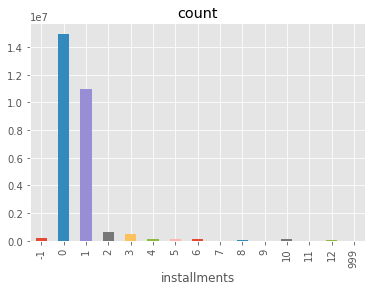

In [12]:
# check installment unique values
# hist_trans_df.loc[hist_trans_df['authorized_flag']=='N', 'installments'].unique()
# new_trans_df.loc[new_trans_df['authorized_flag']=='Y', 'installments'].unique()
# hist_trans_df.loc[hist_trans_df['authorized_flag']=='Y'].groupby('installments').count()
# new_trans_df.loc[hist_trans_df['authorized_flag']=='Y'].groupby('installments').count()
hist_trans_df.loc[hist_trans_df['authorized_flag']=='Y'].groupby('installments').count()['dummy'].plot(kind='bar',
                                                                                                       title='count')
plt.show()

In [13]:
hist_agg_install_df = hist_trans_df.pivot_table(index='card_id',
                                                columns='installments_flag',
                                                values='dummy',
                                                fill_value=0,
                                                dropna=False,
                                                aggfunc=np.sum)
hist_agg_install_df.columns = ['hist_install_count_n', 'hist_install_count_y']
hist_agg_install_df = hist_agg_install_df.reset_index()
hist_agg_install_df.head(5)

,card_id,hist_install_count_n,hist_install_count_y
0,C_ID_00007093c1,125,24
1,C_ID_0001238066,91,32
2,C_ID_0001506ef0,68,0
3,C_ID_0001793786,222,0
4,C_ID_000183fdda,112,37


In [14]:
hist_agg_cat_1_df = hist_trans_df.pivot_table(index='card_id',
                                              columns='category_1',
                                              values='dummy',
                                              fill_value=0,
                                              dropna=False,
                                              aggfunc=np.sum)
hist_agg_cat_1_df.columns = ['hist_cat_1_n', 'hist_cat_1_y']
hist_agg_cat_1_df = hist_agg_cat_1_df.reset_index()
hist_agg_cat_1_df.head(5)

,card_id,hist_cat_1_n,hist_cat_1_y
0,C_ID_00007093c1,121,28
1,C_ID_0001238066,121,2
2,C_ID_0001506ef0,68,0
3,C_ID_0001793786,220,2
4,C_ID_000183fdda,145,4


In [15]:
hist_agg_cat_2_df = hist_trans_df.pivot_table(index='card_id',
                                              columns='category_2',
                                              values='dummy',
                                              fill_value=0,
                                              dropna=False,
                                              aggfunc=np.sum)
hist_agg_cat_2_df.columns = ['hist_cat_2_1', 'hist_cat_2_2', 'hist_cat_2_3', 'hist_cat_2_4', 'hist_cat_2_5']
hist_agg_cat_2_df = hist_agg_cat_2_df.reset_index()
hist_agg_cat_2_df.head(5)

,card_id,hist_cat_2_1,hist_cat_2_2,hist_cat_2_3,hist_cat_2_4,hist_cat_2_5
0,C_ID_00007093c1,0,0,120,0,1
1,C_ID_0001238066,95,0,0,0,20
2,C_ID_0001506ef0,4,0,64,0,0
3,C_ID_0001793786,17,76,15,0,0
4,C_ID_000183fdda,12,1,131,0,1


In [16]:
hist_agg_cat_3_df = hist_trans_df.pivot_table(index='card_id',
                                              columns='category_3',
                                              values='dummy',
                                              fill_value=0,
                                              dropna=False,
                                              aggfunc=np.sum)
hist_agg_cat_3_df.columns = ['hist_cat_3_A', 'hist_cat_3_B', 'hist_cat_3_C']
hist_agg_cat_3_df = hist_agg_cat_3_df.reset_index()
hist_agg_cat_3_df.head(5)

,card_id,hist_cat_3_A,hist_cat_3_B,hist_cat_3_C
0,C_ID_00007093c1,0,125,24
1,C_ID_0001238066,0,88,32
2,C_ID_0001506ef0,67,1,0
3,C_ID_0001793786,217,5,0
4,C_ID_000183fdda,0,108,37


In [17]:
hist_agg_cat_4_df = hist_trans_df.pivot_table(index='card_id',
                                              columns='category_4',
                                              values='dummy',
                                              fill_value=0,
                                              dropna=False,
                                              aggfunc=np.sum)
hist_agg_cat_4_df.columns = ['hist_cat_4_n', 'hist_cat_4_y']
hist_agg_cat_4_df = hist_agg_cat_4_df.reset_index()
hist_agg_cat_4_df.head(5)

,card_id,hist_cat_4_n,hist_cat_4_y
0,C_ID_00007093c1,100,49
1,C_ID_0001238066,103,20
2,C_ID_0001506ef0,1,67
3,C_ID_0001793786,65,157
4,C_ID_000183fdda,7,142


In [18]:
hist_agg_subsector_df = hist_trans_df.pivot_table(index='card_id',
                                                  columns='subsector_id',
                                                  values='dummy',
                                                  fill_value=0,
                                                  dropna=False,
                                                  aggfunc=np.sum)
hist_agg_subsector_df.columns = ['hist_subsector_' + str(i) for i in hist_agg_subsector_df.columns]
hist_agg_subsector_df = hist_agg_subsector_df.reset_index()
# hist_agg_subsector_df['hist_subsector_sum'] = hist_agg_subsector_df.sum(axis=1)
hist_agg_subsector_df.head(5)

,card_id,hist_subsector_-1,hist_subsector_1,hist_subsector_2,hist_subsector_3,hist_subsector_4,hist_subsector_5,hist_subsector_7,hist_subsector_8,hist_subsector_9,...,hist_subsector_32,hist_subsector_33,hist_subsector_34,hist_subsector_35,hist_subsector_36,hist_subsector_37,hist_subsector_38,hist_subsector_39,hist_subsector_40,hist_subsector_41
0,C_ID_00007093c1,0,4,0,0,0,0,0,28,0,...,0,31,7,0,0,0,0,0,0,0
1,C_ID_0001238066,0,4,0,1,0,0,3,0,0,...,0,26,8,0,1,22,1,2,0,0
2,C_ID_0001506ef0,0,1,0,0,0,0,0,3,0,...,0,25,2,0,0,1,0,0,0,0
3,C_ID_0001793786,0,9,3,0,0,0,3,2,1,...,4,30,7,0,6,48,1,0,0,10
4,C_ID_000183fdda,0,8,1,0,0,0,3,0,0,...,2,3,3,2,6,22,1,0,0,0


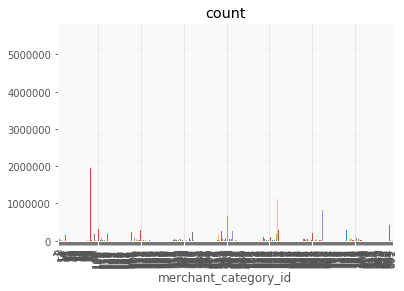

In [19]:
# too many buckts for merchant_category_id
# hist_trans_df['merchant_category_id'].unique()
# hist_trans_df.groupby('merchant_category_id').count()
hist_trans_df.groupby(['merchant_category_id']).count()['dummy'].plot(kind='bar', title='count')
plt.show()

In [20]:
# too many buckts for merchant_group_id
hist_trans_df['merchant_group_id'].unique()

[35, 2084, 27369, 24104, 1348, ..., 109662, 63960, 91990, 82040, 65749]
Length: 108088
Categories (108087, int64): [35, 2084, 27369, 24104, ..., 63960, 91990, 82040, 65749]

####################### Create features from new transactions #######################

In [21]:
# create card features from new transactions - purchase date 
new_agg_date_df = new_trans_df.groupby('card_id')['purchase_date'].agg(['min', 'max']).reset_index()
new_agg_date_df.columns = ['card_id', 'new_date_min', 'new_date_max']
new_agg_date_df.head(5)

,card_id,new_date_min,new_date_max
0,C_ID_00007093c1,2018-04-03 11:13:35,2018-04-09 16:23:59
1,C_ID_0001238066,2018-03-01 16:48:27,2018-04-30 19:57:30
2,C_ID_0001506ef0,2018-03-16 22:21:58,2018-03-22 09:14:30
3,C_ID_0001793786,2017-11-15 15:44:20,2017-12-31 17:35:56
4,C_ID_000183fdda,2018-03-02 12:26:26,2018-04-30 14:59:53


In [22]:
# all new transacations are authorized
new_agg_amount_df = new_trans_df.groupby('card_id')['purchase_amount']\
    .agg(['min', 'max', 'median', 'std', 'sum', 'count']).reset_index()
new_agg_amount_df.columns = ['card_id', 
                             'new_trans_min', 'new_trans_max',
                             'new_trans_median', 'new_trans_std',
                             'new_trans_sum', 'new_trans_count']
new_agg_amount_df.head(5)

,card_id,new_trans_min,new_trans_max,new_trans_median,new_trans_std,new_trans_sum,new_trans_count
0,C_ID_00007093c1,-0.671775,-0.656749,-0.656749,0.008676,-1.985273,3
1,C_ID_0001238066,-0.740897,-0.078318,-0.656749,0.171270,-15.526489,27
2,C_ID_0001506ef0,-0.732001,-0.715352,-0.723677,0.011773,-1.447354,2
3,C_ID_0001793786,-0.737892,3.129932,-0.372748,0.947223,-0.229620,31
4,C_ID_000183fdda,-0.732332,-0.107680,-0.665765,0.182877,-6.590778,11


In [23]:
new_agg_install_df = new_trans_df.pivot_table(index='card_id',
                                              columns='installments_flag',
                                              values='dummy',
                                              fill_value=0,
                                              dropna=False,
                                              aggfunc=np.sum)
new_agg_install_df.columns = ['new_install_count_n', 'new_install_count_y']
new_agg_install_df = new_agg_install_df.reset_index()
new_agg_install_df.head(5)

,card_id,new_install_count_n,new_install_count_y
0,C_ID_00007093c1,3,0
1,C_ID_0001238066,23,4
2,C_ID_0001506ef0,2,0
3,C_ID_0001793786,31,0
4,C_ID_000183fdda,7,4


In [24]:
new_agg_cat_1_df = new_trans_df.pivot_table(index='card_id',
                                            columns='category_1',
                                            values='dummy',
                                            fill_value=0,
                                            dropna=False,
                                            aggfunc=np.sum)
new_agg_cat_1_df.columns = ['new_cat_1_n', 'new_cat_1_y']
new_agg_cat_1_df = new_agg_cat_1_df.reset_index()
new_agg_cat_1_df.head(5)

,card_id,new_cat_1_n,new_cat_1_y
0,C_ID_00007093c1,3,0
1,C_ID_0001238066,25,2
2,C_ID_0001506ef0,2,0
3,C_ID_0001793786,31,0
4,C_ID_000183fdda,11,0


In [25]:
new_agg_cat_2_df = new_trans_df.pivot_table(index='card_id',
                                            columns='category_2',
                                            values='dummy',
                                            fill_value=0,
                                            dropna=False,
                                            aggfunc=np.sum)
new_agg_cat_2_df.columns = ['new_cat_2_1', 'new_cat_2_2', 'new_cat_2_3', 'new_cat_2_4', 'new_cat_2_5']
new_agg_cat_2_df = new_agg_cat_2_df.reset_index()
new_agg_cat_2_df.head(5)

,card_id,new_cat_2_1,new_cat_2_2,new_cat_2_3,new_cat_2_4,new_cat_2_5
0,C_ID_00007093c1,2,0,1,0,0
1,C_ID_0001238066,21,0,0,0,3
2,C_ID_0001506ef0,0,0,2,0,0
3,C_ID_0001793786,15,8,5,0,1
4,C_ID_000183fdda,0,0,11,0,0


In [26]:
new_agg_cat_3_df = new_trans_df.pivot_table(index='card_id',
                                            columns='category_3',
                                            values='dummy',
                                            fill_value=0,
                                            dropna=False,
                                            aggfunc=np.sum)
new_agg_cat_3_df.columns = ['new_cat_3_A', 'new_cat_3_B', 'new_cat_3_C']
new_agg_cat_3_df = new_agg_cat_3_df.reset_index()
new_agg_cat_3_df.head(5)

,card_id,new_cat_3_A,new_cat_3_B,new_cat_3_C
0,C_ID_00007093c1,0,3,0
1,C_ID_0001238066,0,22,4
2,C_ID_0001506ef0,2,0,0
3,C_ID_0001793786,31,0,0
4,C_ID_000183fdda,0,6,4


In [27]:
new_agg_cat_4_df = new_trans_df.pivot_table(index='card_id',
                                            columns='category_4',
                                            values='dummy',
                                            fill_value=0,
                                            dropna=False,
                                            aggfunc=np.sum)
new_agg_cat_4_df.columns = ['new_cat_4_n', 'new_cat_4_y']
new_agg_cat_4_df = new_agg_cat_4_df.reset_index()
new_agg_cat_4_df.head(5)

,card_id,new_cat_4_n,new_cat_4_y
0,C_ID_00007093c1,0,3
1,C_ID_0001238066,16,10
2,C_ID_0001506ef0,0,1
3,C_ID_0001793786,9,22
4,C_ID_000183fdda,0,11


In [28]:
new_agg_subsector_df = new_trans_df.pivot_table(index='card_id',
                                                columns='subsector_id',
                                                values='dummy',
                                                fill_value=0,
                                                dropna=False,
                                                aggfunc=np.sum)
new_agg_subsector_df.columns = ['new_subsector_' + str(i) for i in new_agg_subsector_df.columns]
new_agg_subsector_df = new_agg_subsector_df.reset_index()
new_agg_subsector_df.head(5)

,card_id,new_subsector_-1,new_subsector_1,new_subsector_2,new_subsector_3,new_subsector_4,new_subsector_5,new_subsector_7,new_subsector_8,new_subsector_9,...,new_subsector_32,new_subsector_33,new_subsector_34,new_subsector_35,new_subsector_36,new_subsector_37,new_subsector_38,new_subsector_39,new_subsector_40,new_subsector_41
0,C_ID_00007093c1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C_ID_0001238066,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,8,0,0,0,0
2,C_ID_0001506ef0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
3,C_ID_0001793786,0,0,0,0,0,0,1,0,0,...,0,2,0,0,1,10,0,0,0,1
4,C_ID_000183fdda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [54]:
# merge all generated features
# historical transactions
features_df = pd.merge(hist_agg_date_df,
                       hist_agg_amount_df,
                       on='card_id',
                       how='inner')
features_df = pd.merge(features_df,
                       hist_agg_auth_amount_df,
                       on='card_id',
                       how='inner')
features_df = pd.merge(features_df,
                       hist_agg_install_df,
                       on='card_id',
                       how='inner')
features_df = pd.merge(features_df,
                       hist_agg_cat_1_df,
                       on='card_id',
                       how='inner')
features_df = pd.merge(features_df,
                       hist_agg_cat_2_df,
                       on='card_id',
                       how='inner')
features_df = pd.merge(features_df,
                       hist_agg_cat_3_df,
                       on='card_id',
                       how='inner')
features_df = pd.merge(features_df,
                       hist_agg_cat_4_df,
                       on='card_id',
                       how='inner')
features_df = pd.merge(features_df,
                       hist_agg_subsector_df,
                       on='card_id',
                       how='inner')
# new transactions
features_df = pd.merge(features_df,
                       new_agg_date_df,
                       on='card_id',
                       how='left')
features_df = pd.merge(features_df,
                       new_agg_amount_df,
                       on='card_id',
                       how='left')
features_df = pd.merge(features_df,
                       new_agg_install_df,
                       on='card_id',
                       how='left')
features_df = pd.merge(features_df,
                       new_agg_cat_1_df,
                       on='card_id',
                       how='left')
features_df = pd.merge(features_df,
                       new_agg_cat_2_df,
                       on='card_id',
                       how='left')
features_df = pd.merge(features_df,
                       new_agg_cat_3_df,
                       on='card_id',
                       how='left')
features_df = pd.merge(features_df,
                       new_agg_cat_4_df,
                       on='card_id',
                       how='left')
features_df = pd.merge(features_df,
                       new_agg_subsector_df,
                       on='card_id',
                       how='left')
features_df.head(5)

,card_id,hist_date_min,hist_date_max,hist_trans_min,hist_trans_max,hist_trans_median,hist_trans_std,hist_trans_sum,hist_trans_count,hist_auth_min_n,...,new_subsector_32,new_subsector_33,new_subsector_34,new_subsector_35,new_subsector_36,new_subsector_37,new_subsector_38,new_subsector_39,new_subsector_40,new_subsector_41
0,C_ID_00007093c1,2017-02-14 14:00:43,2018-02-27 05:14:57,-0.728876,1.507069,-0.587627,0.298141,-76.845041,149,-0.728876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C_ID_0001238066,2017-09-28 22:25:14,2018-02-27 16:18:59,-0.734887,0.768095,-0.648184,0.190235,-72.447201,123,-0.596643,...,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
2,C_ID_0001506ef0,2017-01-14 16:16:01,2018-02-17 12:33:56,-0.740491,1.493545,-0.705585,0.466354,-36.037843,68,-0.740491,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C_ID_0001793786,2017-01-21 10:15:21,2017-10-31 20:20:18,-0.745405,4.554145,-0.493185,0.826433,-39.408680,222,-0.745405,...,0.0,2.0,0.0,0.0,1.0,10.0,0.0,0.0,0.0,1.0
4,C_ID_000183fdda,2017-08-07 09:49:14,2018-02-25 20:57:08,-0.737892,2.764788,-0.659754,0.516910,-72.033025,149,-0.714541,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [55]:
features_df.columns.tolist()

['card_id',
 'hist_date_min',
 'hist_date_max',
 'hist_trans_min',
 'hist_trans_max',
 'hist_trans_median',
 'hist_trans_std',
 'hist_trans_sum',
 'hist_trans_count',
 'hist_auth_min_n',
 'hist_auth_min_y',
 'hist_auth_max_n',
 'hist_auth_max_y',
 'hist_auth_median_n',
 'hist_auth_median_y',
 'hist_auth_std_n',
 'hist_auth_std_y',
 'hist_auth_sum_n',
 'hist_auth_sum_y',
 'hist_auth_count_n',
 'hist_auth_count_y',
 'hist_install_count_n',
 'hist_install_count_y',
 'hist_cat_1_n',
 'hist_cat_1_y',
 'hist_cat_2_1',
 'hist_cat_2_2',
 'hist_cat_2_3',
 'hist_cat_2_4',
 'hist_cat_2_5',
 'hist_cat_3_A',
 'hist_cat_3_B',
 'hist_cat_3_C',
 'hist_cat_4_n',
 'hist_cat_4_y',
 'hist_subsector_-1',
 'hist_subsector_1',
 'hist_subsector_2',
 'hist_subsector_3',
 'hist_subsector_4',
 'hist_subsector_5',
 'hist_subsector_7',
 'hist_subsector_8',
 'hist_subsector_9',
 'hist_subsector_10',
 'hist_subsector_11',
 'hist_subsector_12',
 'hist_subsector_13',
 'hist_subsector_14',
 'hist_subsector_15',
 'hist_

In [56]:
# calculate the percentages for each categorical feature - historical transactions
for k in [i for i in features_df.columns
          if ('hist_auth_count' in i)
          or ('hist_install_count' in i)
          or ('hist_cat_1' in i)
          or ('hist_cat_2' in i)
          or ('hist_cat_3' in i)
          or ('hist_cat_4' in i)
          or ('hist_subsector' in i)]:
    features_df[k + '_pct'] = features_df[k] / features_df['hist_trans_count']

# calculate the percentages for each categorical feature - new transactions
for k in [i for i in features_df.columns
          if ('new_install_count' in i)
          or ('new_cat_1' in i)
          or ('new_cat_2' in i)
          or ('new_cat_3' in i)
          or ('new_cat_4' in i)
          or ('new_subsector' in i)]:
    features_df[k + '_pct'] = features_df[k] / features_df['new_trans_count']

In [57]:
features_df.columns.tolist()

['card_id',
 'hist_date_min',
 'hist_date_max',
 'hist_trans_min',
 'hist_trans_max',
 'hist_trans_median',
 'hist_trans_std',
 'hist_trans_sum',
 'hist_trans_count',
 'hist_auth_min_n',
 'hist_auth_min_y',
 'hist_auth_max_n',
 'hist_auth_max_y',
 'hist_auth_median_n',
 'hist_auth_median_y',
 'hist_auth_std_n',
 'hist_auth_std_y',
 'hist_auth_sum_n',
 'hist_auth_sum_y',
 'hist_auth_count_n',
 'hist_auth_count_y',
 'hist_install_count_n',
 'hist_install_count_y',
 'hist_cat_1_n',
 'hist_cat_1_y',
 'hist_cat_2_1',
 'hist_cat_2_2',
 'hist_cat_2_3',
 'hist_cat_2_4',
 'hist_cat_2_5',
 'hist_cat_3_A',
 'hist_cat_3_B',
 'hist_cat_3_C',
 'hist_cat_4_n',
 'hist_cat_4_y',
 'hist_subsector_-1',
 'hist_subsector_1',
 'hist_subsector_2',
 'hist_subsector_3',
 'hist_subsector_4',
 'hist_subsector_5',
 'hist_subsector_7',
 'hist_subsector_8',
 'hist_subsector_9',
 'hist_subsector_10',
 'hist_subsector_11',
 'hist_subsector_12',
 'hist_subsector_13',
 'hist_subsector_14',
 'hist_subsector_15',
 'hist_

In [69]:
# check missing values in each categorical bucket
print('authorized_flag missing #: ', len(hist_trans_df[hist_trans_df['authorized_flag'].isnull()]))
print('installments_flag missing #: ', len(hist_trans_df[hist_trans_df['installments_flag'].isnull()]))
print('category_1 missing #: ', len(hist_trans_df[hist_trans_df['category_1'].isnull()]))
print('category_2 missing #: ', len(hist_trans_df[hist_trans_df['category_2'].isnull()]))
print('category_3 missing #: ', len(hist_trans_df[hist_trans_df['category_3'].isnull()]))
print('category_4 missing #: ', len(hist_trans_df[hist_trans_df['category_4'].isnull()]))
print('subsector_id missing #: ', len(hist_trans_df[hist_trans_df['subsector_id'].isnull()]))
print('=======================================')
print('authorized_flag missing #: ', len(new_trans_df[new_trans_df['authorized_flag'].isnull()]))
print('installments_flag missing #: ', len(new_trans_df[new_trans_df['installments_flag'].isnull()]))
print('category_1 missing #: ', len(new_trans_df[new_trans_df['category_1'].isnull()]))
print('category_2 missing #: ', len(new_trans_df[new_trans_df['category_2'].isnull()]))
print('category_3 missing #: ', len(new_trans_df[new_trans_df['category_3'].isnull()]))
print('category_4 missing #: ', len(new_trans_df[new_trans_df['category_4'].isnull()]))
print('subsector_id missing #: ', len(new_trans_df[new_trans_df['subsector_id'].isnull()]))

authorized_flag missing #:  0
installments_flag missing #:  0
category_1 missing #:  0
category_2 missing #:  2738410
category_3 missing #:  178337
category_4 missing #:  138481
subsector_id missing #:  0
authorized_flag missing #:  0
installments_flag missing #:  0
category_1 missing #:  0
category_2 missing #:  114948
category_3 missing #:  55985
category_4 missing #:  26216
subsector_id missing #:  0


In [72]:
col_fltr =\
['card_id',
 'hist_date_min',
 'hist_date_max',
 'hist_trans_min',
 'hist_trans_max',
 'hist_trans_median',
 'hist_trans_std',
 'hist_trans_sum',
 'hist_trans_count',
 'hist_auth_min_n',
 'hist_auth_min_y',
 'hist_auth_max_n',
 'hist_auth_max_y',
 'hist_auth_median_n',
 'hist_auth_median_y',
 'hist_auth_std_n',
 'hist_auth_std_y',
 'hist_auth_sum_n',
 'hist_auth_sum_y',

 'hist_auth_count_y_pct',
 'hist_install_count_y_pct',
 'hist_cat_1_y_pct',
 'hist_cat_2_1_pct',
 'hist_cat_2_2_pct',
 'hist_cat_2_3_pct',
 'hist_cat_2_4_pct',
 'hist_cat_2_5_pct',
 'hist_cat_3_A_pct',
 'hist_cat_3_B_pct',
 'hist_cat_3_C_pct',
 'hist_cat_4_n_pct',
 'hist_cat_4_y_pct',
 'hist_subsector_1_pct',
 'hist_subsector_2_pct',
 'hist_subsector_3_pct',
 'hist_subsector_4_pct',
 'hist_subsector_5_pct',
 'hist_subsector_7_pct',
 'hist_subsector_8_pct',
 'hist_subsector_9_pct',
 'hist_subsector_10_pct',
 'hist_subsector_11_pct',
 'hist_subsector_12_pct',
 'hist_subsector_13_pct',
 'hist_subsector_14_pct',
 'hist_subsector_15_pct',
 'hist_subsector_16_pct',
 'hist_subsector_17_pct',
 'hist_subsector_18_pct',
 'hist_subsector_19_pct',
 'hist_subsector_20_pct',
 'hist_subsector_21_pct',
 'hist_subsector_22_pct',
 'hist_subsector_23_pct',
 'hist_subsector_24_pct',
 'hist_subsector_25_pct',
 'hist_subsector_26_pct',
 'hist_subsector_27_pct',
 'hist_subsector_28_pct',
 'hist_subsector_29_pct',
 'hist_subsector_30_pct',
 'hist_subsector_31_pct',
 'hist_subsector_32_pct',
 'hist_subsector_33_pct',
 'hist_subsector_34_pct',
 'hist_subsector_35_pct',
 'hist_subsector_36_pct',
 'hist_subsector_37_pct',
 'hist_subsector_38_pct',
 'hist_subsector_39_pct',
 'hist_subsector_40_pct',
 'hist_subsector_41_pct',
 
 'new_date_min',
 'new_date_max',
 'new_trans_min',
 'new_trans_max',
 'new_trans_median',
 'new_trans_std',
 'new_trans_sum',
 'new_trans_count',

 'new_install_count_y_pct',
 'new_cat_1_y_pct',
 'new_cat_2_1_pct',
 'new_cat_2_2_pct',
 'new_cat_2_3_pct',
 'new_cat_2_4_pct',
 'new_cat_2_5_pct',
 'new_cat_3_A_pct',
 'new_cat_3_B_pct',
 'new_cat_3_C_pct',
 'new_cat_4_n_pct',
 'new_cat_4_y_pct',
 'new_subsector_1_pct',
 'new_subsector_2_pct',
 'new_subsector_3_pct',
 'new_subsector_4_pct',
 'new_subsector_5_pct',
 'new_subsector_7_pct',
 'new_subsector_8_pct',
 'new_subsector_9_pct',
 'new_subsector_10_pct',
 'new_subsector_11_pct',
 'new_subsector_12_pct',
 'new_subsector_13_pct',
 'new_subsector_14_pct',
 'new_subsector_15_pct',
 'new_subsector_16_pct',
 'new_subsector_17_pct',
 'new_subsector_18_pct',
 'new_subsector_19_pct',
 'new_subsector_20_pct',
 'new_subsector_21_pct',
 'new_subsector_22_pct',
 'new_subsector_23_pct',
 'new_subsector_24_pct',
 'new_subsector_25_pct',
 'new_subsector_26_pct',
 'new_subsector_27_pct',
 'new_subsector_28_pct',
 'new_subsector_29_pct',
 'new_subsector_30_pct',
 'new_subsector_31_pct',
 'new_subsector_32_pct',
 'new_subsector_33_pct',
 'new_subsector_34_pct',
 'new_subsector_35_pct',
 'new_subsector_36_pct',
 'new_subsector_37_pct',
 'new_subsector_38_pct',
 'new_subsector_39_pct',
 'new_subsector_40_pct',
 'new_subsector_41_pct']

features_df = features_df[col_fltr]
features_df.head(5)

,card_id,hist_date_min,hist_date_max,hist_trans_min,hist_trans_max,hist_trans_median,hist_trans_std,hist_trans_sum,hist_trans_count,hist_auth_min_n,...,new_subsector_32_pct,new_subsector_33_pct,new_subsector_34_pct,new_subsector_35_pct,new_subsector_36_pct,new_subsector_37_pct,new_subsector_38_pct,new_subsector_39_pct,new_subsector_40_pct,new_subsector_41_pct
0,C_ID_00007093c1,2017-02-14 14:00:43,2018-02-27 05:14:57,-0.728876,1.507069,-0.587627,0.298141,-76.845041,149,-0.728876,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,C_ID_0001238066,2017-09-28 22:25:14,2018-02-27 16:18:59,-0.734887,0.768095,-0.648184,0.190235,-72.447201,123,-0.596643,...,0.0,0.037037,0.0,0.0,0.000000,0.296296,0.0,0.0,0.0,0.000000
2,C_ID_0001506ef0,2017-01-14 16:16:01,2018-02-17 12:33:56,-0.740491,1.493545,-0.705585,0.466354,-36.037843,68,-0.740491,...,0.0,0.500000,0.5,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,C_ID_0001793786,2017-01-21 10:15:21,2017-10-31 20:20:18,-0.745405,4.554145,-0.493185,0.826433,-39.408680,222,-0.745405,...,0.0,0.064516,0.0,0.0,0.032258,0.322581,0.0,0.0,0.0,0.032258
4,C_ID_000183fdda,2017-08-07 09:49:14,2018-02-25 20:57:08,-0.737892,2.764788,-0.659754,0.516910,-72.033025,149,-0.714541,...,0.0,0.000000,0.0,0.0,0.000000,0.181818,0.0,0.0,0.0,0.000000


In [74]:
# save and compress into parquet file format
if True:
    features_df.to_parquet('../input/features_df.parquet.gzip',
                           engine='fastparquet',
                           compression='gzip')